# N-BEATS 

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from darts import TimeSeries

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

In [3]:
# Load df
df = pd.read_csv('data/daily_min_temp.csv')
print(df.shape)
df.head()

(3650, 2)


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
# convert to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
# Change to timeseries object
series = TimeSeries.from_dataframe(df, time_col='Date', value_cols=['Temp'], fill_missing_dates=True, freq='d')

<Axes: xlabel='Date'>

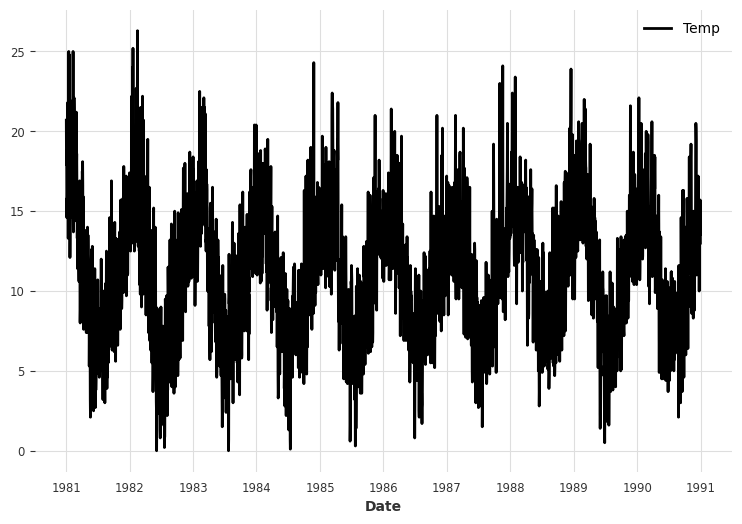

In [6]:
# Visualise
series.plot()

In [7]:
print(len(series))
print(len(df))

3652
3650


In [8]:
# to fill missing data
from darts.utils.missing_values import fill_missing_values

full_series = fill_missing_values(series)

## Train/test split 

<Axes: xlabel='Date'>

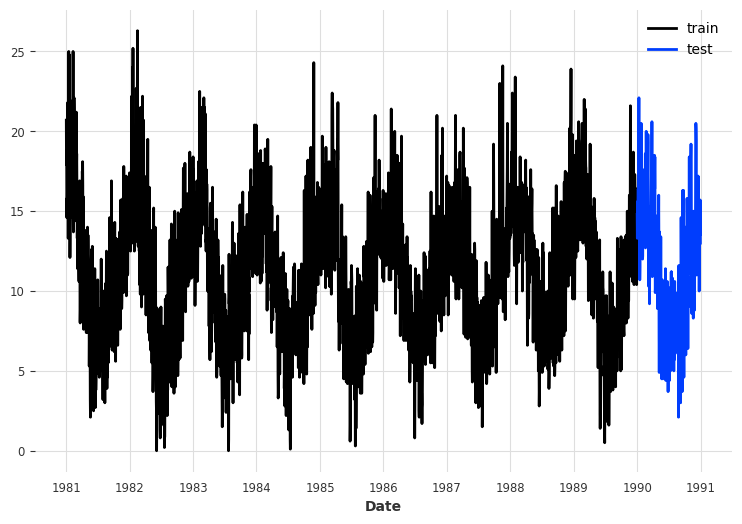

In [9]:
# keep the last 365 days for the test set
train, test = full_series[:-365], full_series[-365:]

train.plot(label='train')
test.plot(label='test')

## Baseline 

In [10]:
from darts.models.forecasting.baselines import NaiveSeasonal

naive_seasonal = NaiveSeasonal(K=365)
naive_seasonal.fit(train)

pred_naive = naive_seasonal.predict(365)

<Axes: xlabel='Date'>

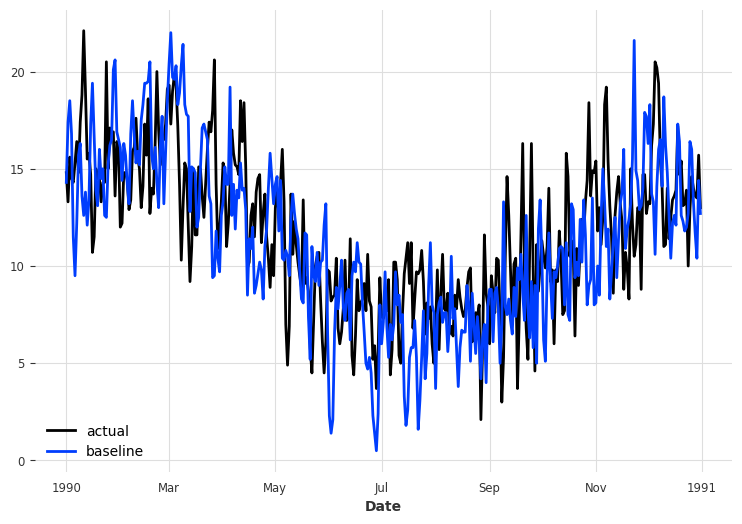

In [11]:
test.plot(label='actual')
pred_naive.plot(label = 'baseline')

## N-BEATS 

In [12]:
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

# Scale the data as a deep learning model and these perform better when scaled
train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

# Now instatiate the model
nbeats = NBEATSModel(
    input_chunk_length=365,
    output_chunk_length=365,
    generic_architecture=True,
    random_state=42
)

nbeats.fit(scaled_train, epochs=15)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.9 M 
---------------------------------------------------
8.9 M     Trainable params
3.5 K     Non-trainable params
8.9 M     Total params
35.763    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=365, output_chunk_length=365, random_state=42)

In [13]:
# predictions are scaled
scaled_pred_nbeats = nbeats.predict(n=365)

# Now convert back from scaling
pred_nbeats = train_scaler.inverse_transform(scaled_pred_nbeats)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

### Evaluation

In [14]:
from darts.metrics import mae

naive_mae = mae(test, pred_naive)
nbeats_mae = mae(test, pred_nbeats)

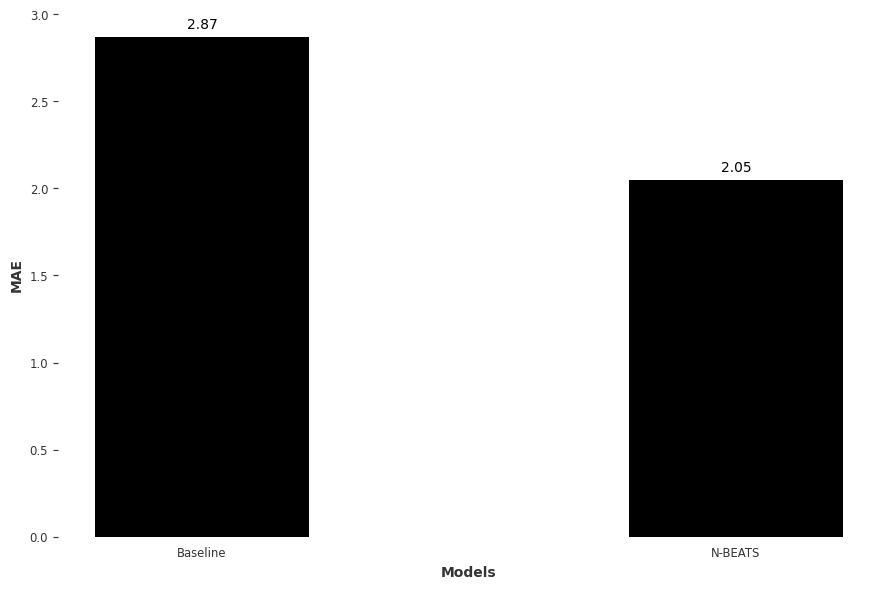

In [15]:
fig, ax = plt.subplots()

x = ['Baseline', 'N-BEATS']
y = [naive_mae, nbeats_mae]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.grid(False)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

### Plot predictions 

<Axes: xlabel='Date'>

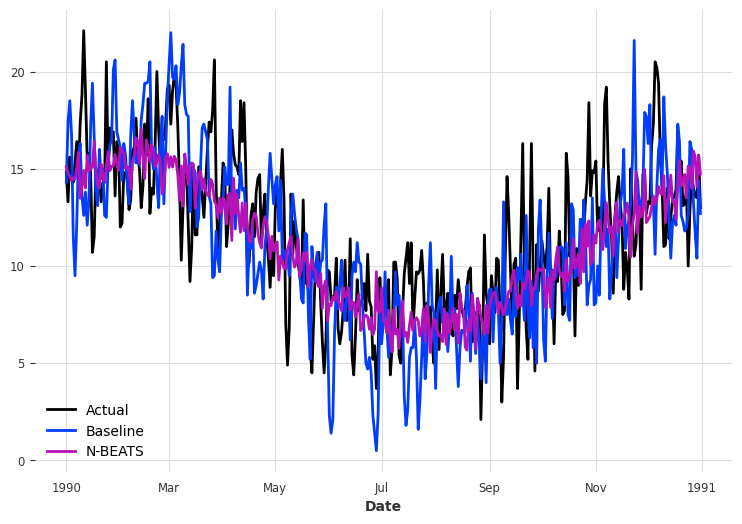

In [16]:
test.plot(label='Actual')
pred_naive.plot(label='Baseline')
pred_nbeats.plot(label='N-BEATS')

## N-BEATS with covariates 

In [17]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

cov = dt_attr(series.time_index, 'month', dtype=np.float32)


In [18]:
cov_scaler = Scaler()

scaled_cov = cov_scaler.fit_transform(cov)

train_scaled_cov, test_sclaed_cov = scaled_cov[:-365], scaled_cov[-365:]

<Axes: xlabel='Date'>

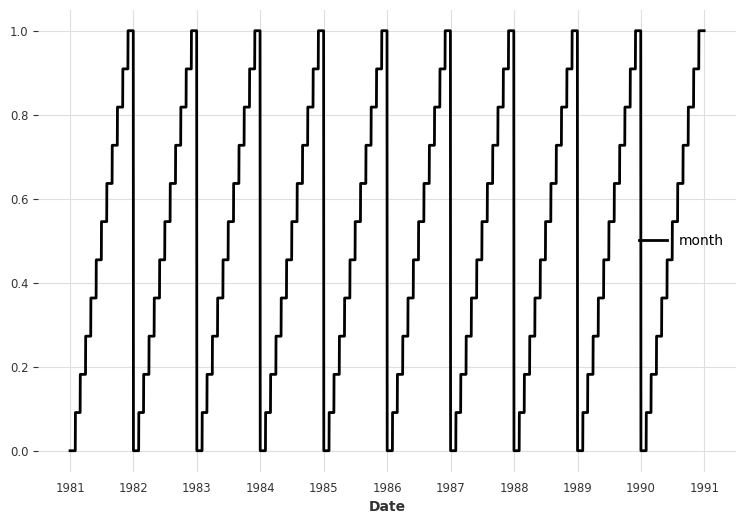

In [19]:
scaled_cov.plot()

In [20]:
nbeats_cov = NBEATSModel(
    input_chunk_length=365,
    output_chunk_length=365,
    generic_architecture=True,
    random_state=42
)

nbeats_cov.fit(scaled_train, past_covariates=scaled_cov, epochs=15)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 11.9 M
---------------------------------------------------
11.9 M    Trainable params
5.7 K     Non-trainable params
11.9 M    Total params
47.501    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=365, output_chunk_length=365, random_state=42)

In [21]:
scaled_pred_nbeats_cov = nbeats_cov.predict(past_covariates=scaled_cov, n=365)

pred_nbeats_cov = train_scaler.inverse_transform(scaled_pred_nbeats_cov)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

### Evaluation 

In [22]:
mae_nbeats_cov = mae(test, pred_nbeats_cov)

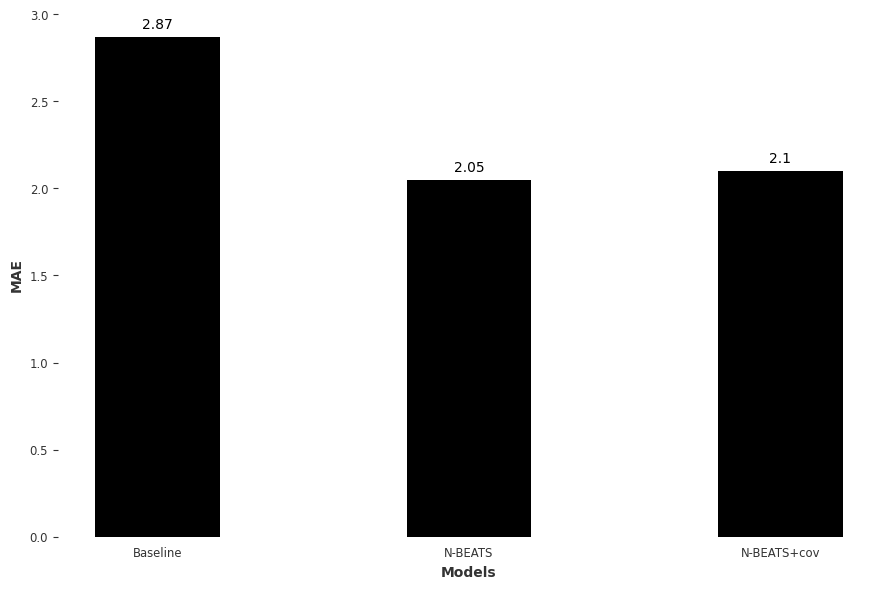

In [23]:
fig, ax = plt.subplots()

x = ['Baseline', 'N-BEATS', 'N-BEATS+cov']
y = [naive_mae, nbeats_mae, mae_nbeats_cov]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.grid(False)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

### Plot predictions 

<Axes: xlabel='Date'>

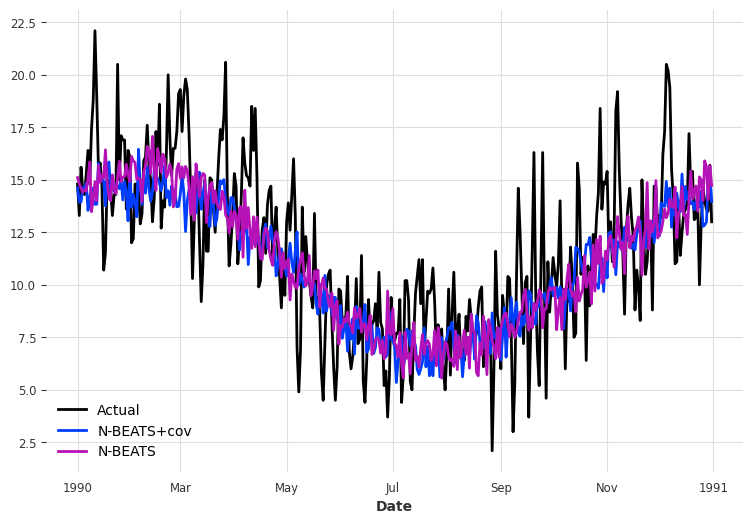

In [24]:
test.plot(label='Actual')
pred_nbeats_cov.plot(label='N-BEATS+cov')
pred_nbeats.plot(label='N-BEATS')